<a href="https://colab.research.google.com/github/wollm/testCNN/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here is my implementation of a CNN using the Resnet-18 model. I am using the popular CIFAR10 dataset from the Canadian Institute For Advanced Research. The dataset consists of 60,000 32x32 colored images in 10 different classes with a perfect distribution of 6,000 images per class. The classes are: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset is split between 50,000 training images and 10,000 test images.

The dataset is commonly used for testing different models and teaching how to finetune different, more complex models. Typical basic model implementations tend to hover anywhere between 70-85% accuracy. While more advanced designs can reach accuracies between 85-95% and state of the art models with meticulous tuning can get accuracies up to 99%!!!

I experimented with a ton of different hyperparameters, augmentation techniques, optimizations, transformers,  and schedulers. I even built code to help me identify the ideal learning rate for my model which was pretty cool. The current configuration below is my most recent and accurate model acheiving an accuracy of 90% on test data after 50 epochs of training. You can see the full code breakdown and implementation below!

Obviously here is where I import all of my dependencies and libraries/modules that I need in order for my program to successfully run. I use pytorch as my main library for building the model. This gives direct access to the CIFAR10 dataset and provides a variety of models and other helpful methods to make the process more streamlined. I also bring in matplotlib to help with graphing and numpy to help with data visualization and maniuplation.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

In this next section, I use a conditional statement to see if a GPU is available. If so, I select that as my running device, if not I default to a CPU.

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Next, I establish my hyperparameters for the model. Here is specify the number of epochs I want to run, the batch size and learning rate.

I also list the names of the classes so I can easily access them at later points in the program

In [ ]:
# Hyper-parameters
num_epochs = 30
batch_size = 128
learning_rate = 0.000459

# Define the class names for later viewing
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In this next section, I augment the training data and normalize the test data.

Augmenting the data is an important step in image classification because it helps your model to better generalize to unseen data and learn to handle a wider variety of inputs. I experimented with a wide variety of different augmentation techniques and values. I found this current implementation to be relatively successful. I do feel though that this is one of the more complex steps in this process and requires a significant amount of time to really learn the best practices for this.

For the testing data, I simply normalize it to make sure it is inline with my training data.

In [ ]:
# Data augmentation for the training data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


# Normalization for the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Here is

In [ ]:
# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


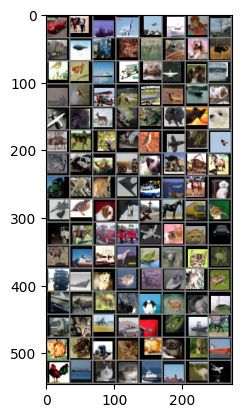

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
# Modify the ResNet-18 model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # Adjusting the final layer for CIFAR-10
model = model.to(device)

# Criterion
criterion = nn.CrossEntropyLoss()

# Optimizer - Switching to Adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Before the training loop
n_total_steps = len(train_loader)

In [ ]:
# Training loop with learning rate scheduling
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_images = 0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {running_loss / 2000:.4f}, Accuracy: {100.0 * total_correct / total_images:.2f}%')
            running_loss = 0.0

    scheduler.step()  # Adjust the learning rate

print('Finished Training')

# Save the trained model
PATH = './cnn_resnet18.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/30], Step [100/391], Loss: 0.0482, Accuracy: 67.54%
Epoch [1/30], Step [200/391], Loss: 0.0447, Accuracy: 68.26%
Epoch [1/30], Step [300/391], Loss: 0.0414, Accuracy: 69.42%
Epoch [2/30], Step [100/391], Loss: 0.0369, Accuracy: 74.96%
Epoch [2/30], Step [200/391], Loss: 0.0367, Accuracy: 74.70%
Epoch [2/30], Step [300/391], Loss: 0.0354, Accuracy: 74.89%
Epoch [3/30], Step [100/391], Loss: 0.0330, Accuracy: 77.22%
Epoch [3/30], Step [200/391], Loss: 0.0320, Accuracy: 77.66%
Epoch [3/30], Step [300/391], Loss: 0.0322, Accuracy: 77.71%
Epoch [4/30], Step [100/391], Loss: 0.0300, Accuracy: 79.17%
Epoch [4/30], Step [200/391], Loss: 0.0288, Accuracy: 79.73%
Epoch [4/30], Step [300/391], Loss: 0.0296, Accuracy: 79.69%
Epoch [5/30], Step [100/391], Loss: 0.0278, Accuracy: 80.73%
Epoch [5/30], Step [200/391], Loss: 0.0281, Accuracy: 80.62%
Epoch [5/30], Step [300/391], Loss: 0.0281, Accuracy: 80.64%


In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 85.07 %
Accuracy of plane: 87.1 %
Accuracy of car: 89.9 %
Accuracy of bird: 80.9 %
Accuracy of cat: 70.2 %
Accuracy of deer: 85.8 %
Accuracy of dog: 73.6 %
Accuracy of frog: 90.8 %
Accuracy of horse: 89.3 %
Accuracy of ship: 91.2 %
Accuracy of truck: 91.9 %


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score
import numpy as np

# Assuming your model, test_loader, and device are already defined and your model has been trained

# Switch model to evaluation mode
model.eval()

# Containers for predictions and actual label
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Collect predictions and actual labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert collected data to numpy arrays for sklearn functions
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Classification report
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=classes))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

# F1 Score
print("F1 Score (Micro): ", f1_score(all_labels, all_preds, average='micro'))
print("F1 Score (Macro): ", f1_score(all_labels, all_preds, average='macro'))

# Since AUC is typically used for binary classification, for multi-class, you need to binarize the labels
# It's more complex for multi-class problems and requires the probabilities of each class
# AUC is not directly applicable to multi-class classification in the same way as binary, so it's often omitted or handled differently

# Accuracy
print("Accuracy: ", accuracy_score(all_labels, all_preds))

# Note: Computing AUC for multi-class classification requires a different approach, usually one-vs-rest (OvR), and is not shown here due to complexity


Classification Report:
               precision    recall  f1-score   support

       plane       0.88      0.87      0.88      1000
         car       0.92      0.91      0.92      1000
        bird       0.85      0.83      0.84      1000
         cat       0.73      0.72      0.72      1000
        deer       0.84      0.87      0.86      1000
         dog       0.81      0.75      0.78      1000
        frog       0.89      0.91      0.90      1000
       horse       0.90      0.90      0.90      1000
        ship       0.91      0.92      0.92      1000
       truck       0.85      0.93      0.89      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Confusion Matrix:
 [[871  10  22   9   7   0   2   5  38  36]
 [ 10 908   1   2   1   2   1   0  14  61]
 [ 27   2 826  27  43  22  29  14   2   8]
 [ 12   7  39 718  43 105  35  18  10  13]
 [  8   2  26  24 871  16 

In [ ]:
def find_learning_rate(model, train_loader, criterion, init_value=1e-7, final_value=10.0, beta=0.98):
    num = len(train_loader) - 1  # number of batches
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer = optim.Adam(model.parameters(), lr=lr)
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)

        # Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses

        # Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss

        # Store the values
        losses.append(smoothed_loss)
        log_lrs.append(np.log10(lr))

        # Do the backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

    return log_lrs, losses

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)  # Adjusting the final layer for CIFAR-10
model = model.to(device)


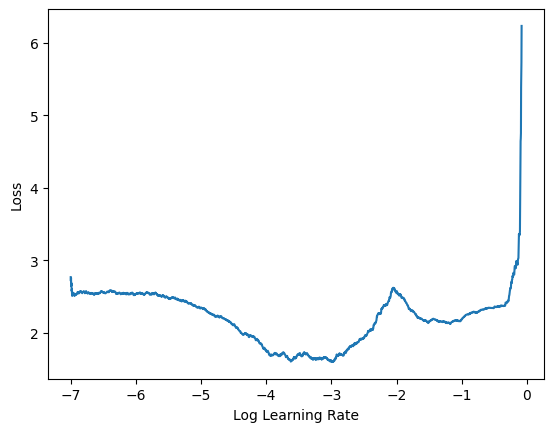

In [ ]:
# Ensure criterion is defined, e.g.,
criterion = nn.CrossEntropyLoss()

# Run the learning rate finder
log_lrs, losses = find_learning_rate(model, train_loader, criterion)

# Plot the results
plt.plot(log_lrs, losses)
plt.xlabel("Log Learning Rate")
plt.ylabel("Loss")
plt.show()
